## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [4]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_Pressure_hp', 'CMtn_WindDirection_deg',
       'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas',
       'CMtn_1hr_Precipitation_mm', 'CMtn_6hr_Precipitation_mm',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=165)


### Create 12 hr snowfall dataframe by using 12hr snowdepth difference

In [6]:
import matplotlib.dates as mdates
#fig = plt.figure(figsize=(10,5))


#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'] = asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']  #.resample('12H').first()
asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'] = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']-asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+1)
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in']
asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'].shift(-1)


asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']>=3]
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3]

shifted_df = pd.DataFrame()
shifted_df = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+12).copy()

#fig = plt.figure(figsize=(30,15))
#plt.subplot(2,1, 1)
#plt.subplots_adjust(hspace=0.5, wspace=0.2)




Let's verify that the 12hr snowfall is doing what we think it is

count    307.000000
mean       4.633453
std        2.186957
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


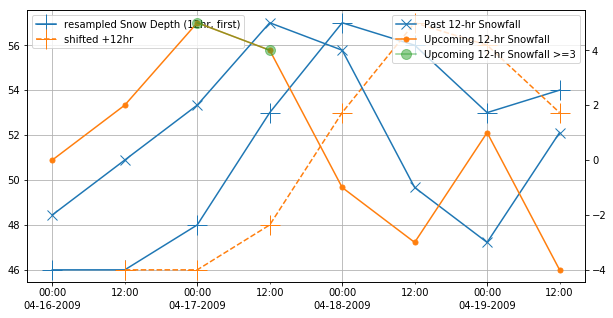

In [7]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'], marker='+', markersize = 20, label = "resampled Snow Depth (12hr, first)")
ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'].shift(+1), marker='+',linestyle='--', markersize = 20, label = "shifted +12hr")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='x', markersize = 10,  label = "Past 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10,  label = "Upcoming 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 20, alpha = 0.5,  label = "Upcoming 12-hr Snowfall >=3")

#ax2 = asos_snotel_UA_df['CMtn_1hr_Precipitation_mm']['01-06-2009':'01-09-2009'].plot(marker='+', markersize = 10, secondary_y = True)

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 
#ax00.set_xlim(100, 12)

#plt.plot(shifted_df, linestyle = '-', linewidth = 10)
#print(shifted_df.describe)

#xlabel('Item (s)')
#ylabel('Value')
#title('Python Line Chart: Plotting numbers')

#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')



#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [ ]:
asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())


***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [8]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


In [9]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.012
Model:                                               OLS   Adj. R-squared:                  0.007
Method:                                    Least Squares   F-statistic:                     2.329
Date:                                   Fri, 01 Feb 2019   Prob (F-statistic):              0.129
Time:                                           11:42:04   Log-Likelihood:                -420.51
No. Observations:                                    189   AIC:                             845.0
Df Residuals:                                        187   BIC:                             851.5
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Run OLS model with all variables

In [ ]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

from collections import OrderedDict

variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


In [ ]:
plt.plot(adjRs)

In [ ]:
plt.plot(f_pvalues)

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [10]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    
    
    


Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

**Perform OLS just on "bad" variables"**

In [ ]:
from collections import OrderedDict

variables = bad_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



In [ ]:
plt.plot(adjRs)
print(adjRs)

In [ ]:
plt.plot(f_pvalues)
print(f_pvalues)

There is some odd behavior here.  Research showed that the high adj R values are due to many missing variable matches to snowfall values, resulting in fictious good fits.  Let's try fitting the model using just the variables with data capture >67%.

### Now run OLS model with the chosen variables ##

In [11]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.14142695943805017
KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.1394473026149592
LXV_WindDirection_

KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.11740767945370834
KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temp

KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.11191171158809565
KGJT_250mb_tmpc+ K

KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ K

KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_

KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d

KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ K

KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_

KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ 

KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_4

KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT

KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d3

LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb

KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_

KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ 

KGJT_d300_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_spe

CMtn_WindSpeed_mps+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_25

**Create plot of adjusted R squared**

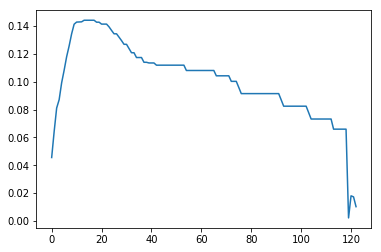

In [12]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

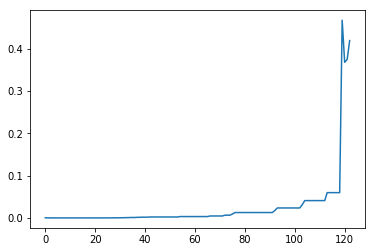

In [13]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [14]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, asos_snotel_UA_df['2008':'2017']).fit()



0 KGJT_500mb_speed_kts 
 Adjusted R: 0.04553977545010446  Fstat(prob): 0.0004000599323753463

1 LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.06427099947708004  Fstat(prob): 0.0001010393208108517

2 KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.08110703463236646  Fstat(prob): 2.7005377925662583e-05

3 KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.0871087141202681  Fstat(prob): 3.109184239299076e-05

4 KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.0992693389976077  Fstat(prob): 1.3313866814339115e-05

5 KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.1082734043581487  Fstat(prob): 8.940373820373918e-06

6 KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_


26 KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.13446094412810894  Fstat(prob): 8.026407332051698e-05

27 LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_

41 KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.11349786617081115  Fstat(prob): 0.0017495902133426032

42 KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_2


52 KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmp

59 KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT_d300_250_drct+ KGJT_200mb_dwpc+ KGJT_500mb_tmpc+ KGJT_300mb_speed_kts+ KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+


66 KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_d700_200_drct+ KGJT_200mb_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d850_300_height_m+ KGJT_850mb_height_m+ KGJT

74 KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_400_height_m+ KGJT_d700_500_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC

80 KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_m+ KGJT_d400_200_tmpc+ KGJT_d400_250_tmpc+ KGJT_d500_400_drct+ KGJT_d400_300_drct+ KGJT_d400_250_drct+ KGJT_d700_4

85 KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_200mb_tmpc+ KGJT_d700_400_tmpc+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_200mb_height_


91 KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+ KGJT_d300_250_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_400_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc

96 KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d500_200_drct+ KGJT_d500_250_tmpc+ KGJT_d700_200_tmpc+

100 KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700_250_drct+ KGJT_500mb_drct+ KGJT_d700_500_drct+ KGJT_300mb_drct+ KGJT_d700_300_drct

104 KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_250mb_drct+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d700

108 KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_200mb_speed_kts+ KGJT_2

112 KGJT_d400_200_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_height_m+ KGJT_d300_200_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_d700_300_speed_kts

116 KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250_speed_kts+ KGJT_d700_250_height_m+ KGJT_d500_250_height_m+ KGJT_d400_250_hei

120 CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_200_dwpc+ KGJT_d300_250_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_700mb_dwpc+ KGJT_400mb_dwpc+ KGJT_d700_200_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_250mb_dwpc+ LXV_WindSpeed_mps+ KGJT_400mb_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_300_height_m+ KGJT_d850_700_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_700mb_height_m+ KGJT_d700_200_height_m+ KGJT_d400_300_height_m+ KGJT_400mb_height_m+ KGJT_d300_250_height_m+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d400_250

**Find max adj R and obtain OLS summary**

In [15]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts


In [16]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_all.summary())


KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.195
Model:                                               OLS   Adj. R-squared:                  0.144
Method:                                    Least Squares   F-statistic:                     3.840
Date:                                   Fri, 01 Feb 2019   Prob (F-statistic):           7.65e-06
Time:                                           11:50:22   Log-Likelihood:                -511.77
No. Observations:                                    237   AIC:                             1054.
Df Residuals:                    

**Print QQ plot**

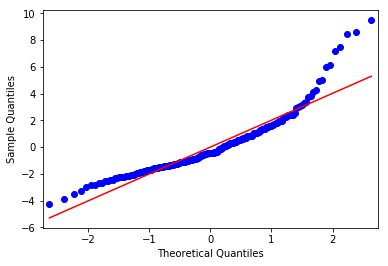

In [17]:
qq2=sm.qqplot(maxOLS_all.resid, line='r')

**There are a few variables with P|t| values which are high, noteably the KGJT_d500_300_speed_kts variable with P|t| of 0.9, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [18]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df['2008':'2017']).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_goodp.summary())


KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
1
KGJT_500mb_dwpc+ KGJT_d700_400_height_m+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.026382557506246296 0.01
0.026382557506246296 0.01
2
KGJT_500mb_dwpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.037489093728965917 0.02
0.037489093728965917 0.02
3
KGJT_500mb_dwpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.037489093728965917 0.03
4
KGJT_500mb_dwpc+ KGJT_700mb_drct+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.09565151206078226 0.04
0.09565151206078226 0.04
5
KGJT_500mb_dwpc+ KGJT_700mb_drct+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_deg

KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.41000000000000003
42
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.42
43
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.43
44
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_

KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.7000000000000001
71
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.71
72
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.72
73
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_k

KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.98
99
KGJT_500mb_dwpc+ KGJT_300mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d500_300_drct+ KGJT_d500_200_dwpc+ KGJT_700mb_drct+ KGJT_700mb_tmpc+ KGJT_d700_400_height_m+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ KGJT_d700_250_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.14420105687699714 0.99

 best threshold is:0.3
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.195
Model:                                               OLS   Adj. R-squared:                  0.144
Method:                                    Least Squares   F-statis

**So it looks like the best P|t| threshold for variable elimination is 0.3.  By doing, this the adjusted R squared only increased slightly to 0.144**

## Try fit parameters with test dataset (2006 and 2007 data)

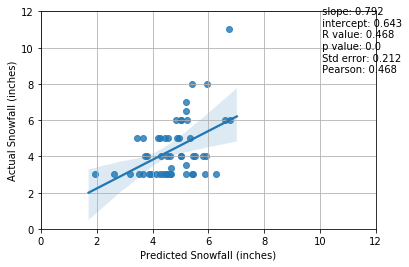

In [19]:

from scipy.stats import pearsonr, linregress
#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3].describe())

actual_snf = asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
#print(actual_snf.describe())


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
sns.regplot(predict[idx], actual_snf[idx])

#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([0,12])
plt.ylim([0,12])
plt.grid(True)
#print(actual_snf.describe())
#print(predict.describe())

[4.93419367 3.64059905 5.01047429 4.88865732 4.57043268 5.19224624
 5.7991395  3.81297288 5.93092882 4.63559025 4.30159946 5.4302777
 5.33539405 5.95715548 5.88052427 5.02929105 6.73737162 5.21616218
 6.58958786 3.67070024 4.50525958 5.02408785 4.26014261 4.27211967
 5.22185137 4.4422801  5.01213821 3.72460444 4.62904682 3.51510998
 4.18664401 4.84781748 1.95359011 3.44201273 4.12721444 4.65127314
 5.20321051 5.19441443 4.37613506 4.48800384 2.60382666 3.86974097
 3.94802222 5.50631245 3.19665932 6.77364459 4.52214036 5.46638874
 5.45335519 6.28963526 4.66812243 5.39830315]
[ 5.    5.    4.    5.    5.    7.    4.    4.    4.    3.    4.    8.
  5.    8.    3.    6.   11.    3.    6.    3.    3.    4.    3.    5.
  6.    5.    6.    4.    4.    3.    5.    6.    3.    5.    3.    3.33
  6.5   3.5   3.    3.    3.    3.    3.    4.    3.    6.    4.    4.
  3.    3.    3.    3.  ]
[ 0.06580633  1.35940095 -1.01047429  0.11134268  0.42956732  1.80775376
 -1.7991395   0.18702712 -1.930928

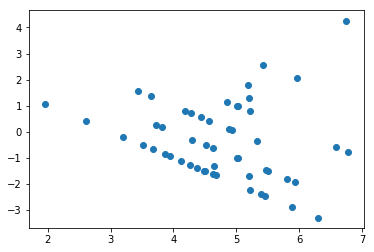

In [25]:
plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
print(actual_snf[idx].values-predict[idx].values)

#print(type(predict))
#print(type(actual_snf))
#sns.regplot(predict[idx], actual_snf[idx]-predict[idx])
diff = actual_snf[idx].values-predict[idx].values
PercentSuccess1 = len([x for x in diff if abs(x)<=1])/len(diff)
PercentSuccess15 = len([x for x in diff if abs(x)<=1.5])/len(diff)
PercentSuccess2= len([x for x in diff if abs(x)<=2])/len(diff)
print(PercentSuccess1, PercentSuccess15, PercentSuccess2)